In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.integrate import solve_ivp

rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', labelsize=20)
rc("axes", linewidth=1)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
rc('legend', fontsize=20)
rc('ytick', right='True',direction= 'in')
rc('xtick', top='True',direction= 'in')
rc('xtick.major', pad=15)
rc('ytick.major', pad=15)
rc('xtick.major', size=12)
rc('ytick.major', size=12)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)

# Corrections to the white dwarf structure

Here we solve the stellar structure equations including Coulomb corrections to the EOS:
\begin{equation}
    P(\rho) = K\rho^{5/3}\left[1-(\rho_0/\rho)^{1/3}\right]
\end{equation}

In [3]:
#Defining the constants
mu_e = 2.
K = 1e13*pow(mu_e,-5./3.)
Z = 6
rho_0 = 0.4*Z*Z*mu_e

G = 6.674e-8
Msun = 2e33
Rsun = 6.957e10

In [4]:
def dp_drho(q): #using the EOS
    return (K/3.)*(5*pow(q,2./3.)*(1-pow(rho_0/q,1./3.))+pow(q*rho_0,1./3.))
    
def modif_EOS(r, y):
    m, rho = y
    dm_dr = 4*np.pi*r*r*rho #mass equation
    drho_dr = -G*m*rho/(r*r*dp_drho(rho)) #from hydrostatic equilibrium equation
    return[dm_dr,drho_dr]

In [5]:
def term_cond(r, y): #termination condition : rho = rho_0
    return y[1]-rho_0
term_cond.terminal = True

rho_c = np.logspace(6,9,8)
sol = []
for rc in rho_c:
    y0 = [1e-12,rc] #initial condition y0[0] = m[0],y0[1] = rho_c
    sol.append(solve_ivp(modif_EOS, [1e-10, 1e15], y0=y0 ,method = 'RK45', dense_output=True,events=term_cond))
    
m,rho,p,r = [],[],[],[] #arrays to store the stellar structure quantities
for i in range(len(sol)):
    m.append(sol[i].y[0])
    rr = sol[i].y[1]
    rho.append(rr)
    r.append(sol[i].t)
    pp = []
    for j in range(len(sol[i].y[1])):
        pp.append(K*pow(rr[j],5./3.)*(1-pow(rho_0/rr[j],1./3.))) #using the EOS
    p.append(pp)

<ipython-input-4-0657099593aa>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (K/3.)*(5*pow(q,2./3.)*(1-pow(rho_0/q,1./3.))+pow(q*rho_0,1./3.))


#### Plotting the stellar structure quantities

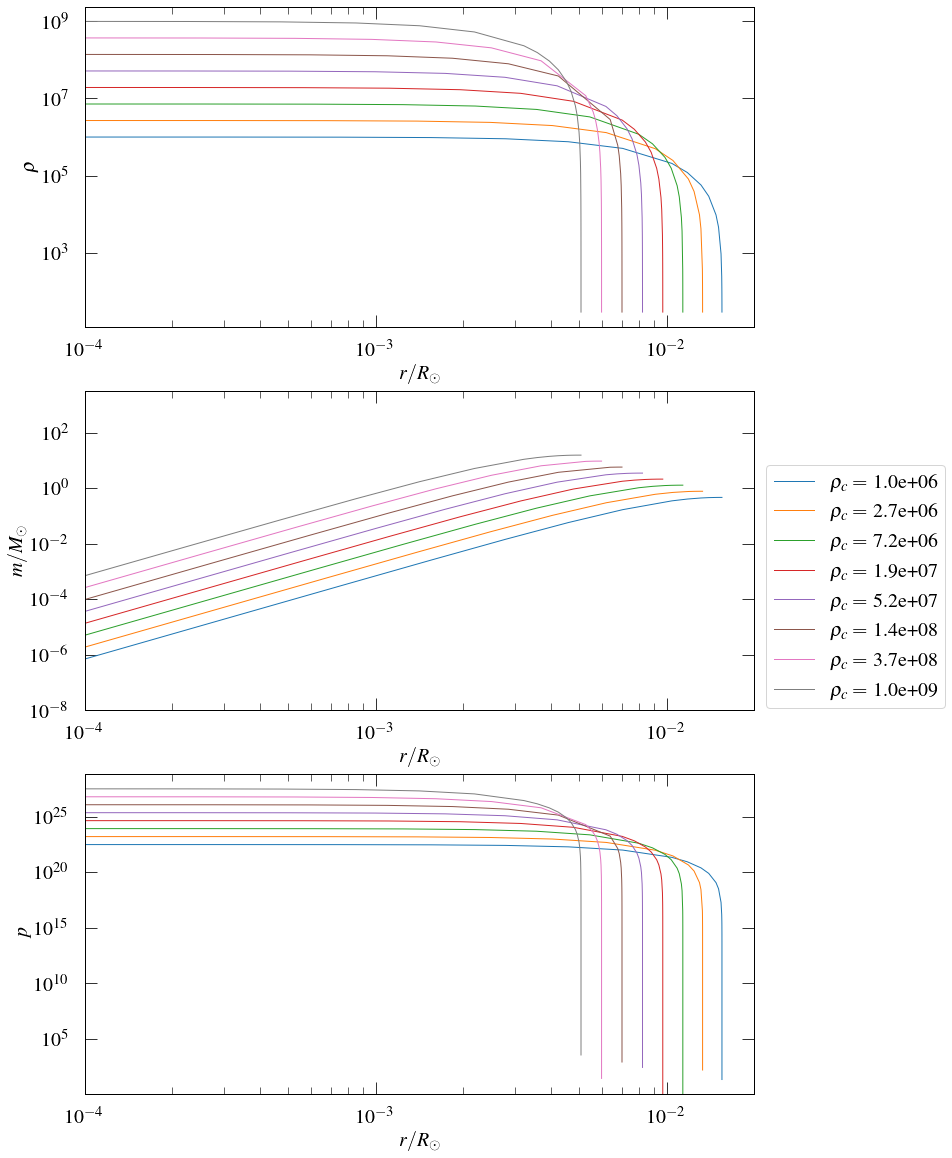

In [9]:
plt.figure(figsize = (12,20))
plt.subplot(3,1,1)
for i in range(len(sol)):
    plt.loglog(r[i]/Rsun,rho[i],label=r'$\rho_c =$ %3.1e'%rho_c[i])
plt.ylabel(r'$\rho$')
plt.xlabel(r'$r/R_\odot$')
plt.xlim(left = 1e-4, right = 2e-2)

plt.subplot(3,1,2)
for i in range(len(sol)):
    plt.loglog(r[i]/Rsun,m[i]/Msun,label=r'$\rho_c =$ %3.1e'%rho_c[i])
plt.ylabel(r'$m/M_\odot$')
plt.xlabel(r'$r/R_\odot$')
plt.xlim(left = 1e-4, right = 2e-2)
plt.ylim(bottom = 1e-8)

plt.subplot(3,1,3)
for i in range(len(sol)):
    plt.loglog(r[i]/Rsun,p[i],label=r'$\rho_c =$ %3.1e'%rho_c[i])
plt.ylabel(r'$p$')
plt.xlabel(r'$r/R_\odot$')
plt.xlim(left = 1e-4, right = 2e-2)

plt.legend(bbox_to_anchor=(1.3, 2.))
plt.show()

### Now, we plot the Mass-Radius relationship for the given EOS

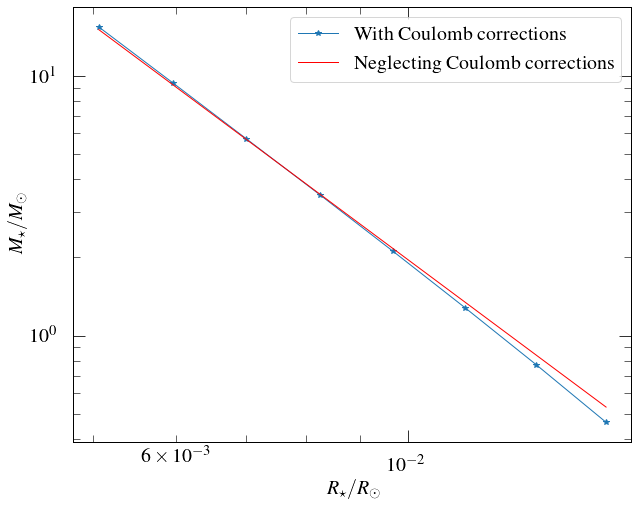

In [7]:
#With Coulomb corrections
Rstar, Mstar = np.zeros(len(sol)), np.zeros(len(sol))
for i in range(len(sol)):
    Rstar[i] = r[i][-1]
    Mstar[i] = m[i][-1]

#Neglecting Coulomb corrections
rref = np.linspace(min(Rstar),max(Rstar))
mref = np.zeros(len(rref))
n = 3./2. #polytropic index
C = (n+1)*K/(4*np.pi*G)
xi_star, dt_dx = 3.6,-0.21 #obtained from tutorial-4
for ii in range(len(rref)):
    mref[ii]=4*np.pi*pow(rref[ii],(3-n)/(1-n))*pow(C,n/(n-1))*pow(xi_star,(3-n)/(n-1)+2)*abs(dt_dx)

#Plotting the comparison plots
plt.figure(figsize = (10,8))
plt.loglog(Rstar/Rsun,Mstar/Msun,'-*',label = 'With Coulomb corrections')
plt.loglog(rref/Rsun,mref/Msun,label = 'Neglecting Coulomb corrections',color = 'r')
plt.xlabel(r'$R_\star/R_\odot$')
plt.ylabel(r'$M_\star/M_\odot$')
plt.legend()
plt.show()